In [ ]:
!jupyter nbconvert --to PDF "Untitled.ipynb"

Names (in an alphabetic order): Ryan , Saeyan, and Yuhui

# Loan Approval Prediction
The goal of this project is classifying "loan_status" properly. There are several way to resolve a classification problem such as logistic regression, logistic regression with regularization, tree-based methods, SVM, neural networks, etc.

In this project, we focus on a neural network model, CATboost, LightGBM, and XGBoost models. We compare the methods with ROC-AUC values, choose the best model, and predict the test dataset with the best model.

# Step 0. Import packages and Set the data path

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')
# For neural network
import torch
from torch import nn
import tqdm
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
# For CATboost
#from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
#import optuna
#from optuna.samplers import TPESampler
from tqdm import tqdm
import time
# For LightGBM
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
#import optuna
from sklearn.preprocessing import LabelEncoder
# For XGBoost
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = "./drive/MyDrive/loan_approval_data/train.csv"
test_path = "./drive/MyDrive/loan_approval_data/test.csv"
sample_sub_path = "./drive/MyDrive/loan_approval_data/sample_submission.csv"

In [ ]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

train.info(10)
test.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

# Step 1. Exploratory Data Analysis (EDA)

For the EDA, we check descriptive statistics and histgrams (skewness and kurtosis), check the outliers using boxplots, create scatterplots (linearity), and check the correlations among predictors (collinearity).

Before we move on to EDA, we check the 11 predictors' data type.

1. Continuous variables (4): person_home_ownership, loan_intent, loan_grade, cb_person_default_on_file
2. Categorical variables (7): person_age, person_income, person_emp_length, loan_amnt, loan_int_rate, loan_percent_income, cb_person_cred_hist_length

Also, we can see that the sample sizes from the train and the test datasets are imbalanced:

n = 58645 for train
n = 39098 for test

## 1.1. Check the descriptive statistics

In [ ]:
continuous_variables = train.select_dtypes(exclude=["object"])
categorical_cols = train.select_dtypes(include = ['object']).columns
continuous_variables2 = train.select_dtypes(exclude=["object"]).drop(columns=['id', 'loan_status']).columns

In [ ]:
train.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [ ]:
test.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,39098.000000,39098.000000,3.909800e+04,39098.000000,39098.000000,39098.000000,39098.000000,39098.000000
mean,78193.500000,27.566781,6.406046e+04,4.687068,9251.466188,10.661216,0.159573,5.830707
std,11286.764749,6.032761,3.795583e+04,3.868395,5576.254680,3.020220,0.091633,4.072157
min,58645.000000,20.000000,4.000000e+03,0.000000,700.000000,5.420000,0.000000,2.000000
25%,68419.250000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000
50%,78193.500000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000
75%,87967.750000,30.000000,7.588500e+04,7.000000,12000.000000,12.990000,0.210000,8.000000
max,97742.000000,94.000000,1.900000e+06,42.000000,35000.000000,22.110000,0.730000,30.000000


In [ ]:
#continuous_variables = train.select_dtypes(exclude=["object"])
# check the descriptive stats and the missingness at the same time.
desc_train_continous = continuous_variables.describe()
# check the skewness and kurtosis
skewness = continuous_variables.skew()
kurtosis = continuous_variables.kurt()

# Add skew and kurt to desc_train
desc_train_continous.loc['skewness'] = skewness
desc_train_continous.loc['kurtosis'] = kurtosis

print(desc_train_continous)

                    id    person_age  person_income  person_emp_length  \
count     58645.000000  58645.000000   5.864500e+04       58645.000000   
mean      29322.000000     27.550857   6.404617e+04           4.701015   
std       16929.497605      6.033216   3.793111e+04           3.959784   
min           0.000000     20.000000   4.200000e+03           0.000000   
25%       14661.000000     23.000000   4.200000e+04           2.000000   
50%       29322.000000     26.000000   5.800000e+04           4.000000   
75%       43983.000000     30.000000   7.560000e+04           7.000000   
max       58644.000000    123.000000   1.900000e+06         123.000000   
skewness      0.000000      1.965497   1.045772e+01           2.054430   
kurtosis     -1.200000      6.408380   3.426294e+02          29.131606   

             loan_amnt  loan_int_rate  loan_percent_income  \
count     58645.000000   58645.000000         58645.000000   
mean       9217.556518      10.677874             0.159238   

In advance, we will do "One-hot Encoding" for person_home_ownership, loan_intent, cb_person_default_on_file (nominal), and "Label Encoding" for loan_grade (ordinal).

loan_status
0    50295
1     8350
Name: count, dtype: int64
loan_status
0    85.761787
1    14.238213
Name: proportion, dtype: float64


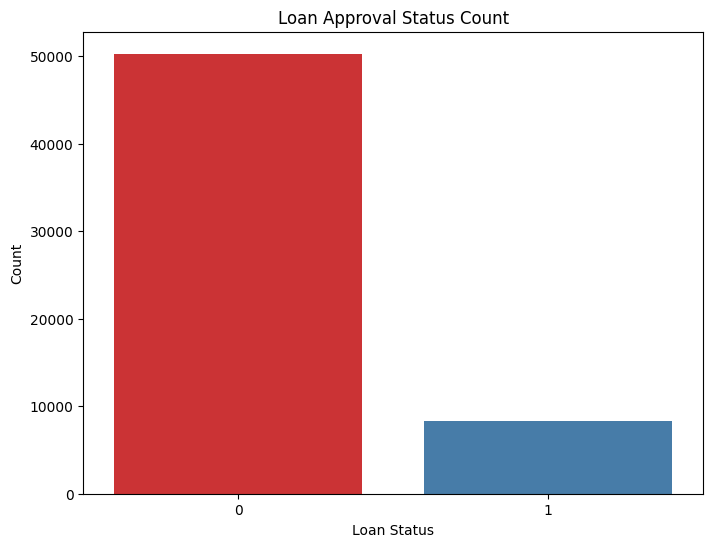

In [ ]:
# 2.1 Check the target variable
target_counts = train['loan_status'].value_counts()
print(target_counts)
target_percentages = train['loan_status'].value_counts(normalize=True) * 100
print(target_percentages)
# imbalanced binary target variable (50295 (85.76%) vs. 8350 (14.24%))

plt.figure(figsize=(8, 6))
sns.countplot(x='loan_status', data=train, palette='Set1')
plt.title('Loan Approval Status Count')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.show()

From the histogram and percentages, we can see that the data is massively inbalanced in favor of the 0 (i.e. 'not approved') class for the loan status

In [ ]:
#2.2 Check the continuous variables
continuous_variables2 = train.select_dtypes(exclude=["object"]).drop(columns=['id', 'loan_status']).columns

print("Continuous variables:")
print(continuous_variables2)
print("-" * 40)


Continuous variables:
Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length'],
      dtype='object')
----------------------------------------


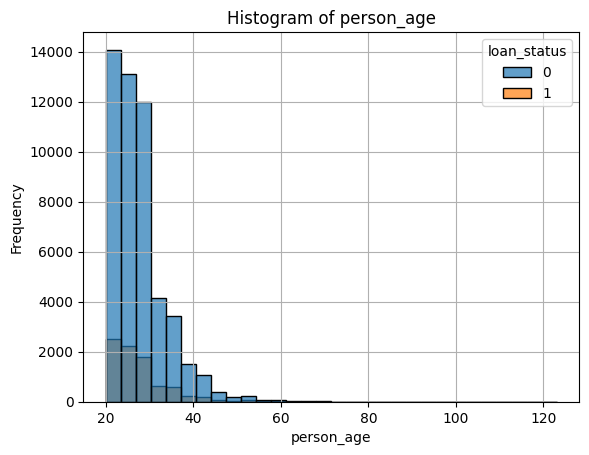

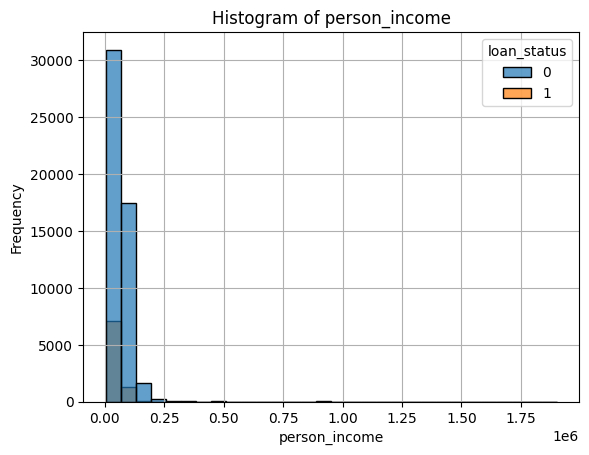

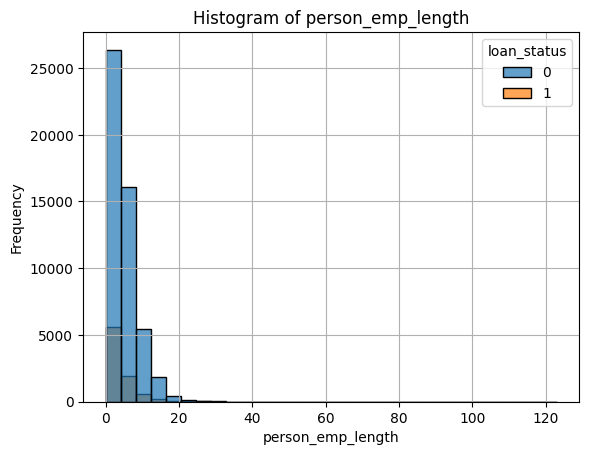

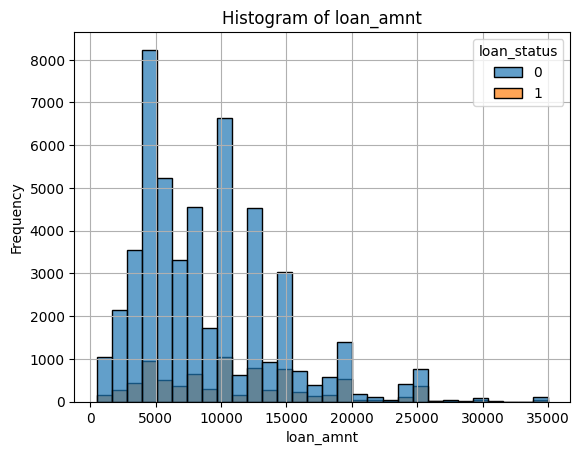

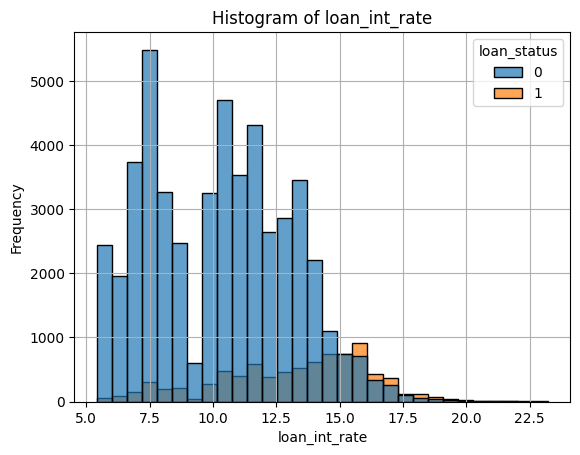

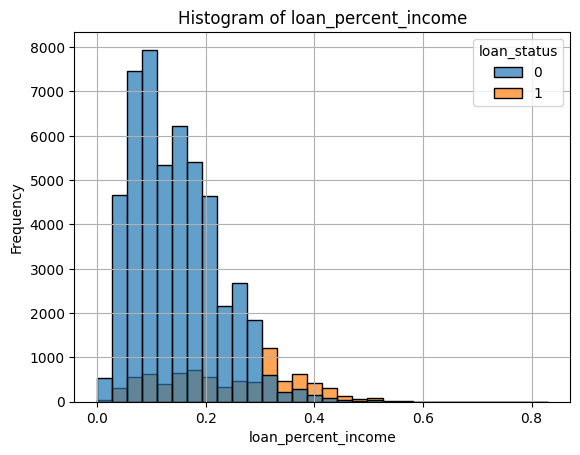

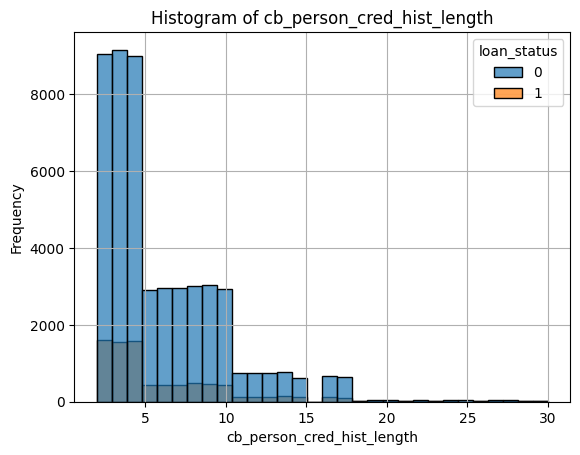

In [ ]:
# check the distribution shapes

# Loop through each continuous variable and create a histogram
for col in continuous_variables2:
  sns.histplot(data=train, x=col, hue='loan_status', bins=30, edgecolor='k', alpha=0.7)
  plt.title(f'Histogram of {col}')
  plt.xlabel(col)
  plt.ylabel('Frequency')
  plt.grid(True)
  plt.show()

## 1.2. Check the outliers

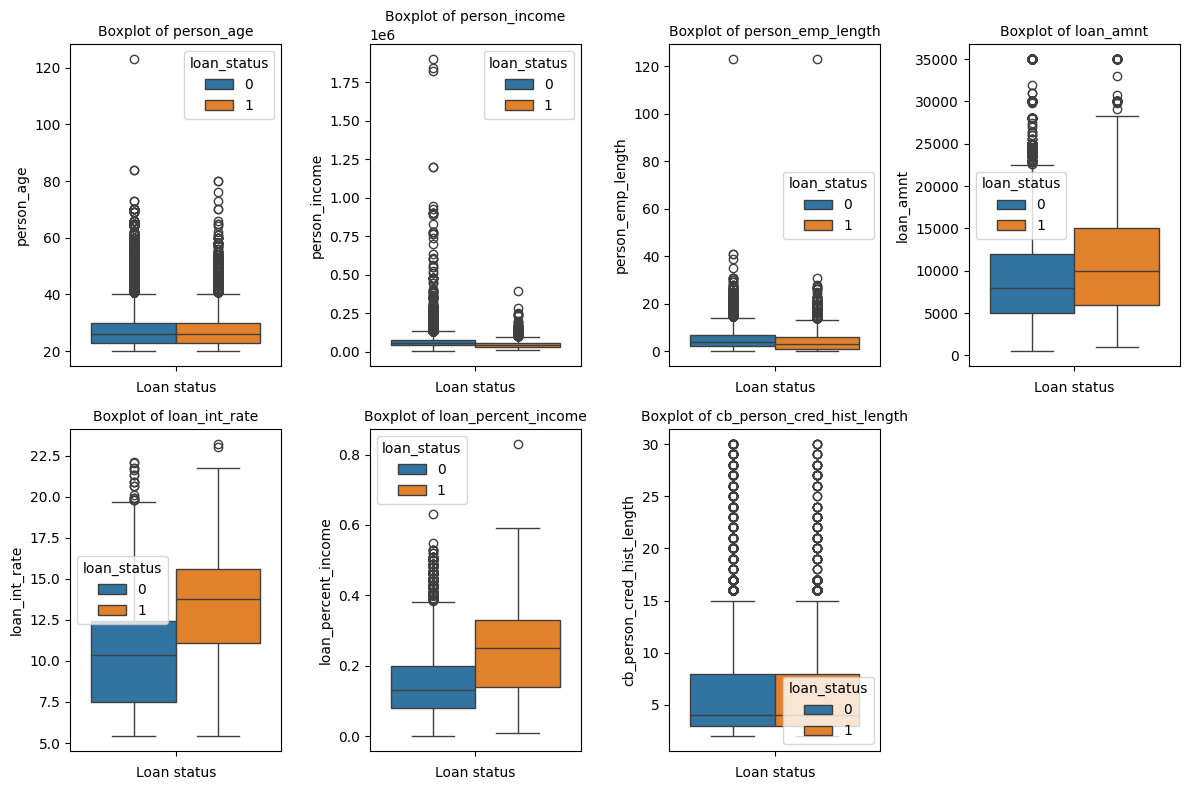

In [ ]:
# check outliers using the box plots
fig, axs = plt.subplots(2,4, figsize=(12, 8))

for feat, ax in zip(continuous_variables2, axs.ravel()):
    sns.boxplot(y=feat, data=train, ax=ax, hue='loan_status')
    ax.set_title(f"Boxplot of {feat}", size=10)
    ax.set_xlabel("Loan status")


fig.delaxes(axs.ravel()[7])
plt.tight_layout()
plt.show()

In [ ]:
# check the outliers
def detect_outliers(df, column):
    Q1 = np.quantile(df[column], 0.25)
    Q3 = np.quantile(df[column], 0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - (1.5 * IQR)
    upper_limit = Q3 + (1.5 * IQR)

    return df[(df[column] < lower_limit) | (df[column] > upper_limit)]

for feat in continuous_variables2:
    outliers = detect_outliers(train, feat)
    print(f"Outliers in column {feat}: {outliers.shape[0]}")

Outliers in column person_age: 2446
Outliers in column person_income: 2411
Outliers in column person_emp_length: 1274
Outliers in column loan_amnt: 2045
Outliers in column loan_int_rate: 34
Outliers in column loan_percent_income: 1210
Outliers in column cb_person_cred_hist_length: 1993


## 1.3. Check the relationships beween predictors and the outcome variable

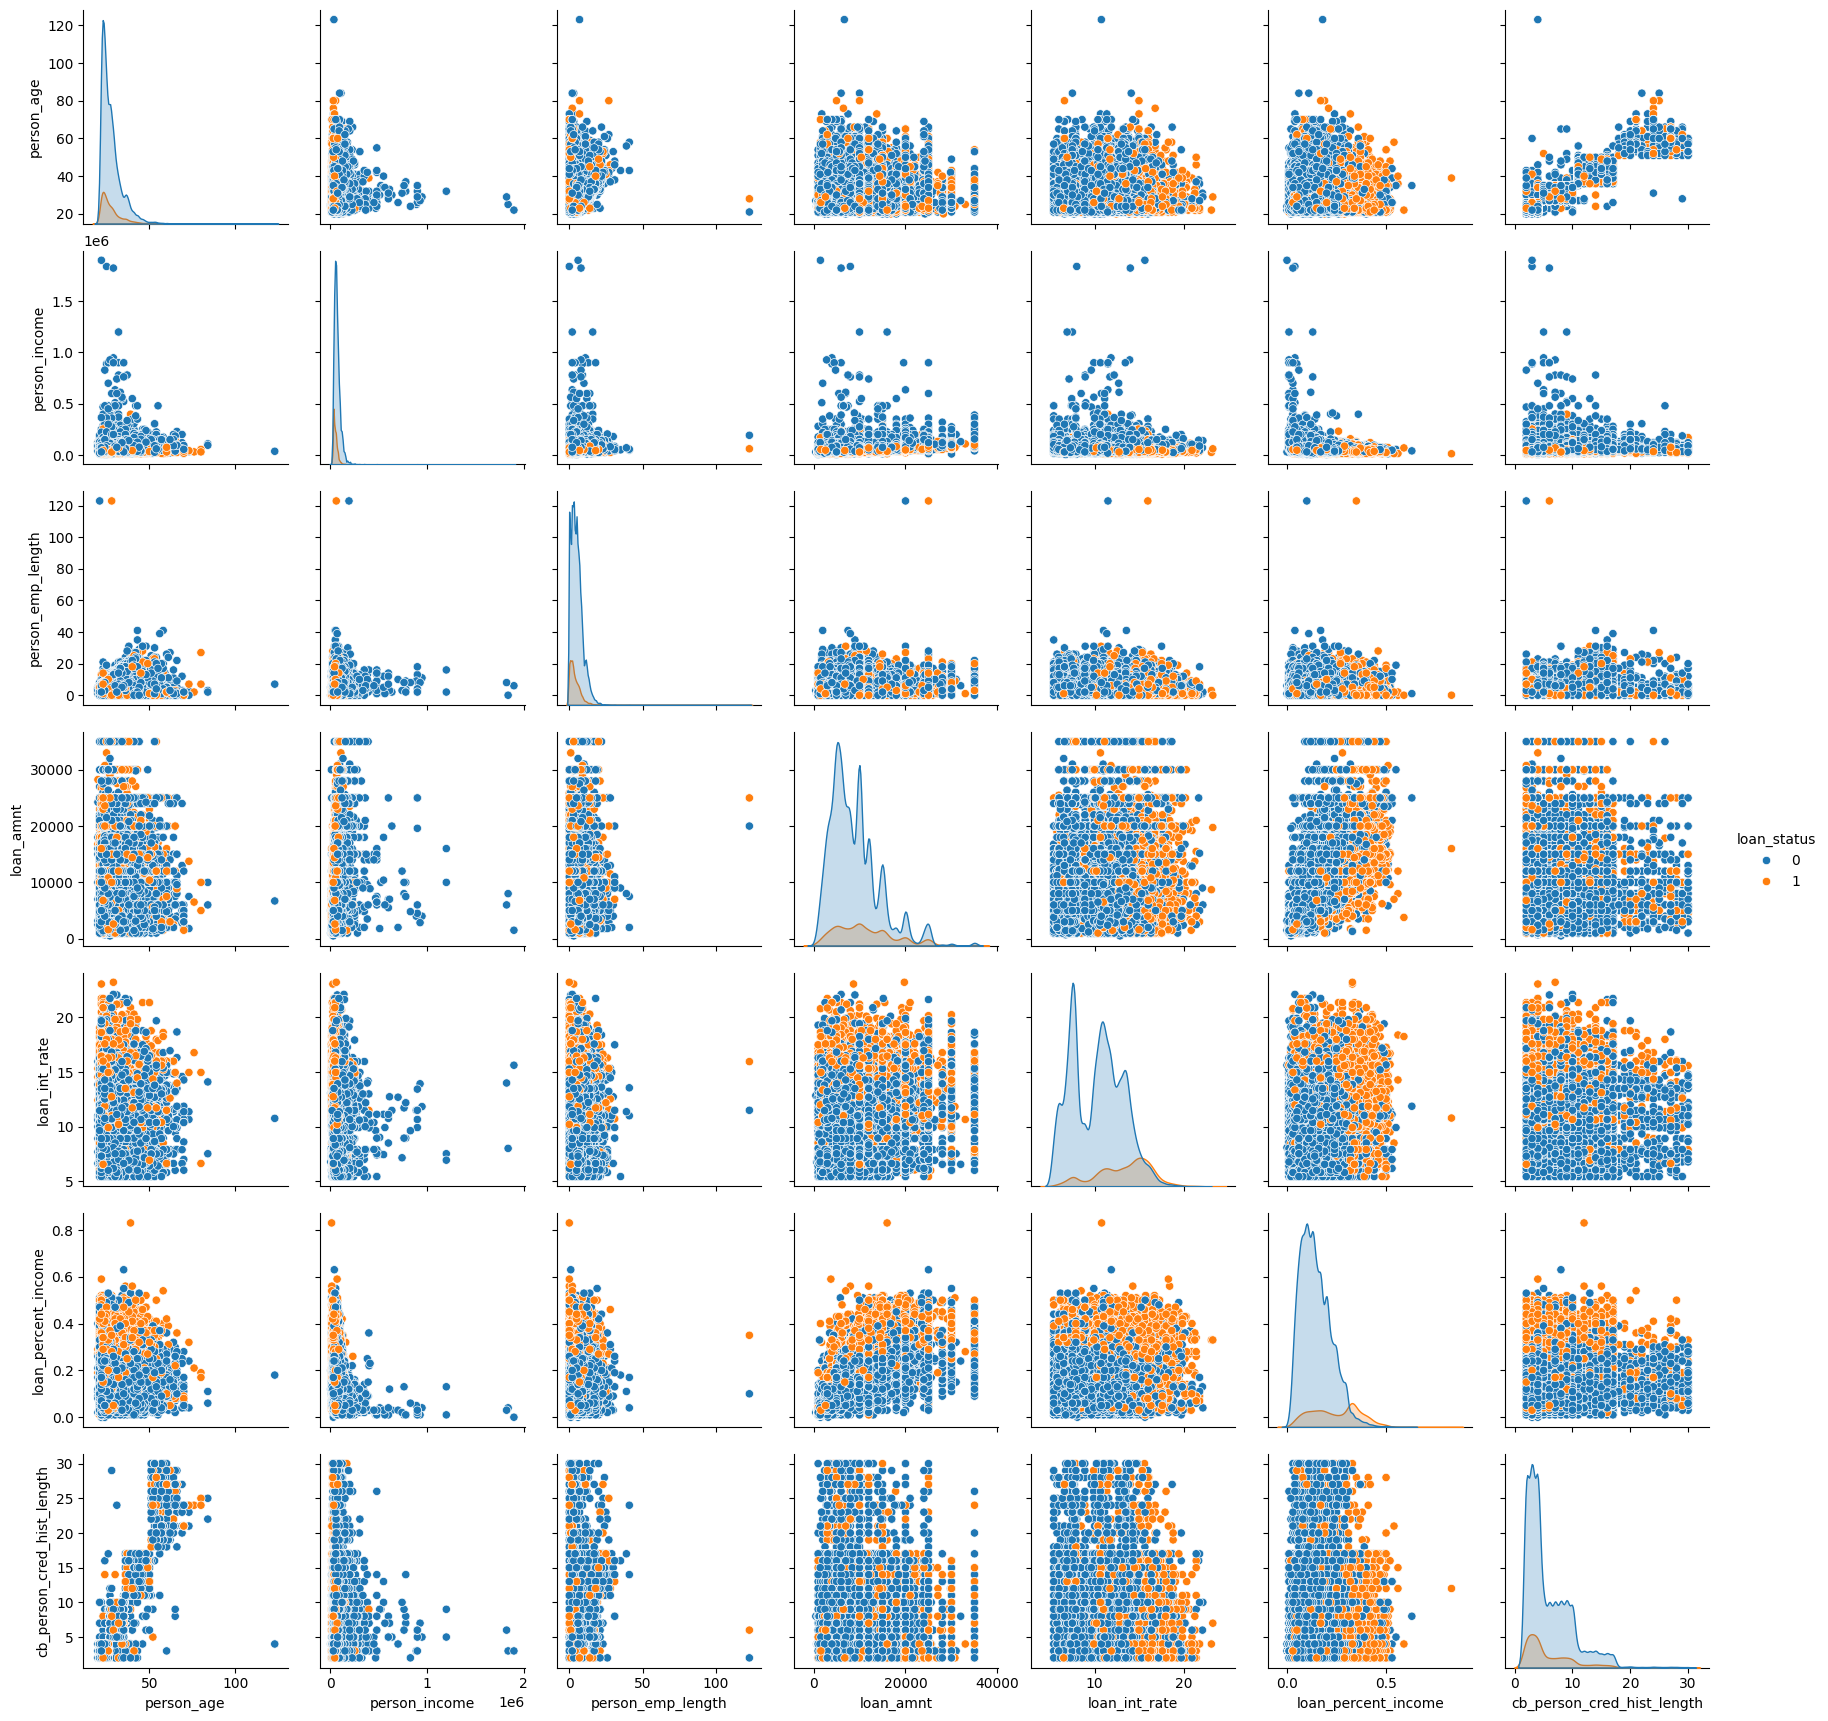

In [ ]:
# check the relationships among continuous variables
continuous_variables3 = train.select_dtypes(exclude=["object"]).drop(columns='id').columns
sns.pairplot(train[continuous_variables3], hue='loan_status')
plt.show()

In [ ]:
# check the correlation matrix
# Select the numeric columns from the train dataset, excluding 'id' and 'loan_status'
continuous_variables2 = train.select_dtypes(exclude=["object"]).drop(columns=['id', 'loan_status'])

# Calculate the correlation matrix for the selected continuous variables
corr_matrix_continuous = continuous_variables2.corr()

# Display the correlation matrix
print(corr_matrix_continuous)

                            person_age  person_income  person_emp_length  \
person_age                    1.000000       0.102176           0.121276   
person_income                 0.102176       1.000000           0.164042   
person_emp_length             0.121276       0.164042           1.000000   
loan_amnt                     0.050378       0.310942           0.092046   
loan_int_rate                 0.009653      -0.057611          -0.101910   
loan_percent_income          -0.031975      -0.280314          -0.065824   
cb_person_cred_hist_length    0.874260       0.082727           0.102842   

                            loan_amnt  loan_int_rate  loan_percent_income  \
person_age                   0.050378       0.009653            -0.031975   
person_income                0.310942      -0.057611            -0.280314   
person_emp_length            0.092046      -0.101910            -0.065824   
loan_amnt                    1.000000       0.113582             0.647266   
loan_i

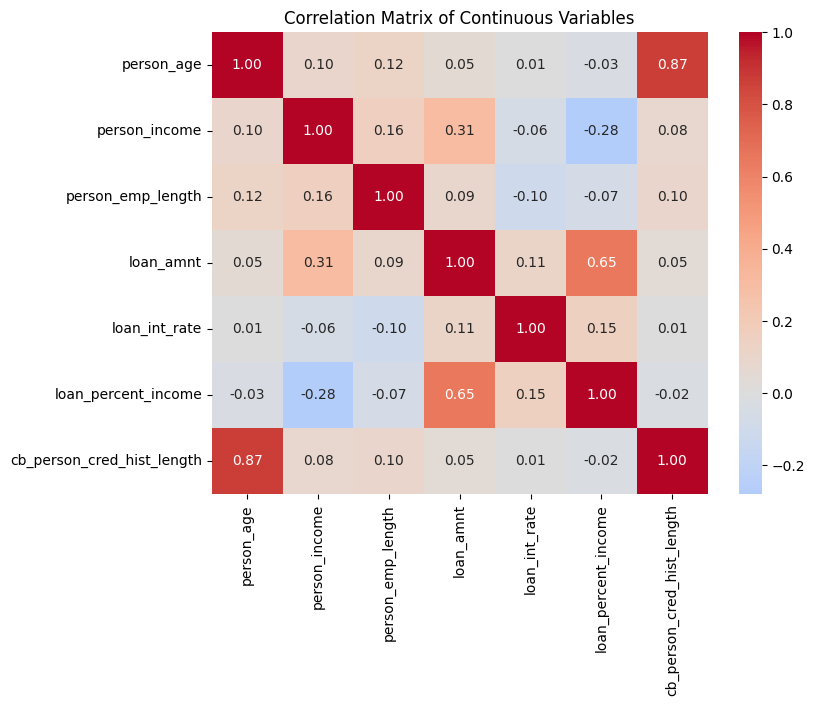

In [ ]:
# Create a heatmap for the correlation matrix
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.heatmap(corr_matrix_continuous, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Continuous Variables")
plt.show()

In [ ]:
# check the categorical variables
# Get more information for the categorical variables
categorical_cols = train.select_dtypes(include = ['object']).columns

print("Categorical columns:")
print(categorical_cols)
print("-" * 40)

for col in categorical_cols:
    unique_values = train[col].unique()
    num_unique = len(unique_values) #len = length
    print(f"Column: {col}")
    print(f"Number of unique values: {num_unique}")
    print(f"Unique values: {unique_values}")
    print("-" * 40)

for col in categorical_cols:
    print(f"Value counts for column: {col}")
    print(train[col].value_counts())
    print("-" * 40)

#train.head(10)

Categorical columns:
Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')
----------------------------------------
Column: person_home_ownership
Number of unique values: 4
Unique values: ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
----------------------------------------
Column: loan_intent
Number of unique values: 6
Unique values: ['EDUCATION' 'MEDICAL' 'PERSONAL' 'VENTURE' 'DEBTCONSOLIDATION'
 'HOMEIMPROVEMENT']
----------------------------------------
Column: loan_grade
Number of unique values: 7
Unique values: ['B' 'C' 'A' 'D' 'E' 'F' 'G']
----------------------------------------
Column: cb_person_default_on_file
Number of unique values: 2
Unique values: ['N' 'Y']
----------------------------------------
Value counts for column: person_home_ownership
person_home_ownership
RENT        30594
MORTGAGE    24824
OWN          3138
OTHER          89
Name: count, dtype: int64
----------------------------------------
Value counts for 

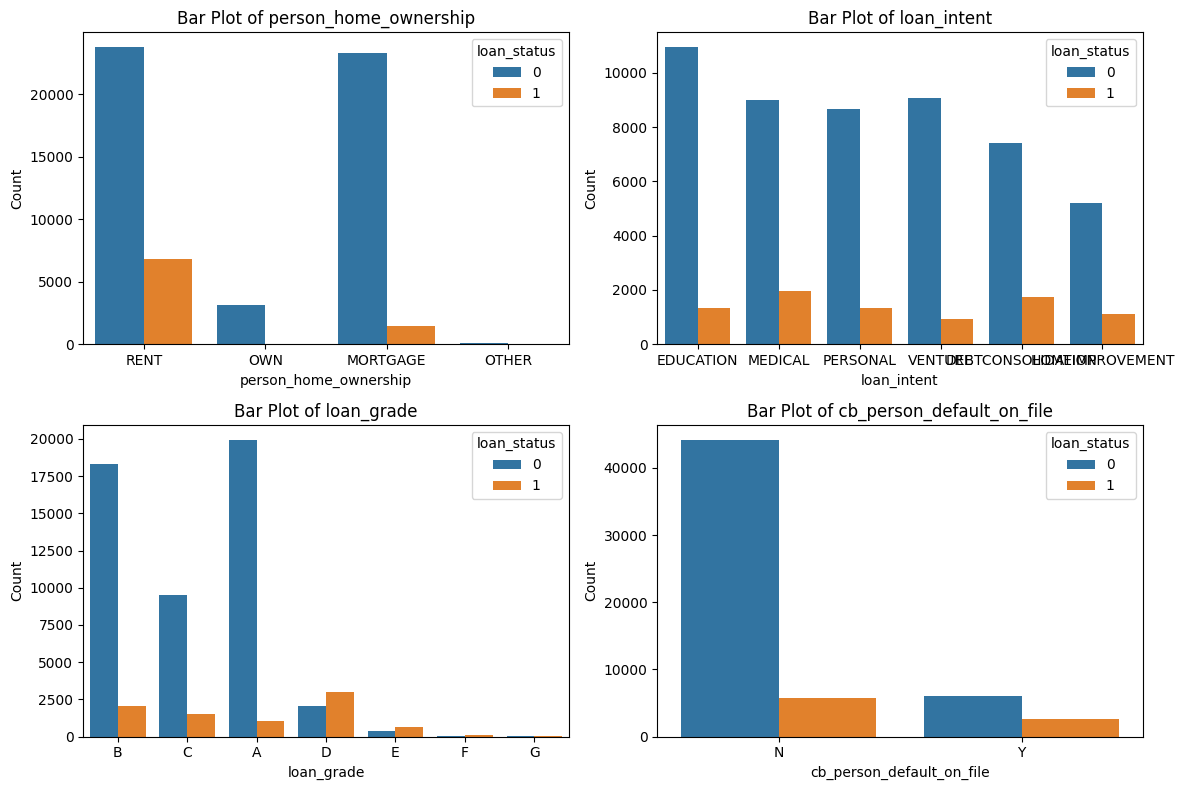

In [ ]:
# Define the number of rows and columns for the subplots
n_rows = 2
n_cols = 2

# Create a figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))

# Flatten the axes array for easy iteration (useful for 2D grids)
axes = axes.flatten()

# Loop through each categorical variable and create a bar plot
for i, col in enumerate(categorical_cols):
    sns.countplot(data=train, x=col, ax=axes[i], hue='loan_status')
    axes[i].set_title(f'Bar Plot of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [ ]:
# Check the Cramer's V correlation
# from scipy.stats import chi2_contingency

# Define a function to calculate Cramér's V
def cramers_v(x, y):
    """Calculate Cramér's V statistic for two categorical variables."""
    # Create a contingency table
    confusion_matrix = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()  # Total number of observations
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

# Create an empty DataFrame to store the Cramér's V correlation matrix
cramers_v_matrix = pd.DataFrame(np.zeros((len(categorical_cols), len(categorical_cols))),
                                index=categorical_cols,
                                columns=categorical_cols)

# Calculate Cramér's V for each pair of categorical variables
for col1 in categorical_cols:
    for col2 in categorical_cols:
        cramers_v_matrix.loc[col1, col2] = cramers_v(train[col1], train[col2])

# Display the Cramér's V correlation matrix
print(cramers_v_matrix)

                           person_home_ownership  loan_intent  loan_grade  \
person_home_ownership                   1.000000     0.092263    0.121097   
loan_intent                             0.092263     1.000000    0.029098   
loan_grade                              0.121097     0.029098    1.000000   
cb_person_default_on_file               0.100496     0.025318    0.645359   

                           cb_person_default_on_file  
person_home_ownership                       0.100496  
loan_intent                                 0.025318  
loan_grade                                  0.645359  
cb_person_default_on_file                   0.999933  


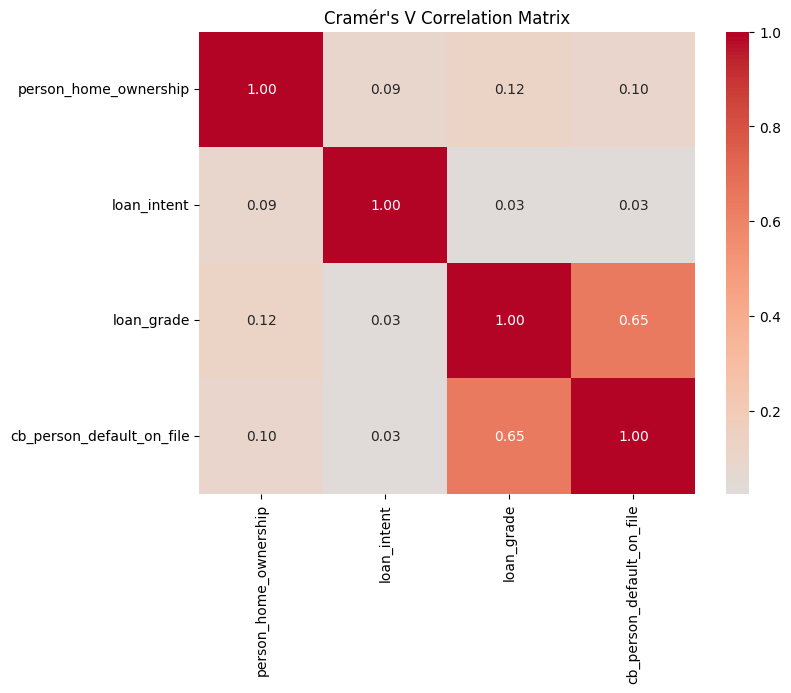

In [ ]:
# Create a heatmap of the Cramér's V correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cramers_v_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Cramér's V Correlation Matrix")
plt.show()

## Take-aways from EDA

- The descriptive statistics showed us that the values of means and standard deviations are similar across the train and test sets.

- We checked skewness and kurtosis of continuous variables from the training dataset, and we can see that they are positively skewed.

- To detect the outliers, we used boxplots and the interqualtile ranges for continuous variables from the training dataset. The largest outliers were from person_age (n = 2,446), which is less than 5% of the entire sample size (n = 58,645). Therefore, the outliers are not problematic.

- From the histogram, we can see that despite the imbalance in data by the class of loan_status, the histograms of the variables show similar patterns across loan_status 0 and 1.

- To see the linearity, we created pair plots among continuous variables. We can see a positive strong linear relationship between cb_person_cred_hist_length and person_age. Also, loan_percent_income and loan_amnt showed a positive moderate linear relationship. On the other hand, it is hard to say that other variables show linearity.

- Based on our observations from pair plots, we checked collinearity between continous variables using Pearson's correlations. The two noticeable values are corresponds with our initial insights from the pair plots, the correlation between cb_person_cred_hist_length, and person_age was *r* = 0.87 and the correlation between loan_percent_income and loan_amnt was *r* = 0.65.

- We used Cramér's V for checking the correlations between categorical variables. The correlation between cb_person_default_on_file and loan_grade is close to 0.7 (*r* = 0.65).


However, we have one to consider before we dive into neural nets and boosting methods.


- The large imbalance in the classes of loan_status means that we need to take that into consideration when training models. For boosting models, this won't be problematic, but for neural nets handling imbalance issue in the outcome variable class might improve the model. Therefore, we will use SMOTE function in advance of predicting with neural networks.

  **&rArr;  Based on the EDA, we concluded that logistic regression is not suitable for this project because non-linearity and multicollinearity. Also, the predictor variables are not normally distributed. We can handle skewness, non-linearity, and multicollinearity for logistic regression. However, considering the sufficient sample size, we conclude that using machine learning methods is appropriate for this project. Specifically, we chose CATboost and LightBGM because they are known as showing good performance for the categorical variable classification problem. Also, we wanted to compare the performance with neural nets and XGBoost.**



# Step 2. Predictive Models

## 2.1. Dense Neural Network

In [ ]:
import torch
from torch import nn
import tqdm
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

In [ ]:
X = train.drop(columns=['loan_status', 'id'])
y = train['loan_status']

In [ ]:
X_dummy = pd.get_dummies(X, columns=['loan_intent','person_home_ownership', 'loan_grade', 'cb_person_default_on_file'], drop_first=True)

In [ ]:
X_np = X_dummy.to_numpy(dtype=float)
y_np = np.reshape(y, (len(y),1))

In [ ]:
X_trans = StandardScaler().fit_transform(X_np)

(array([50295.,     0.,  8350.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <BarContainer object of 3 artists>)

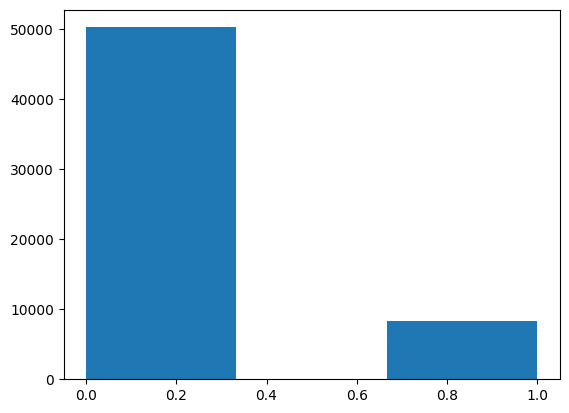

In [ ]:
plt.hist(y_np, bins=3)

N. V. Chawla, K. W. Bowyer, L. O.Hall, W. P. Kegelmeyer, “SMOTE: synthetic minority over-sampling technique,” Journal of artificial intelligence research, 321-357, 2002.

- We want to "increase the sensitivity of network to minority class", i.e. we want it be able to classify as 1 (loan approved) with greater accuracy to increase ROC score.

In [ ]:
smote = SMOTE(random_state=23)

Xres, yres = smote.fit_resample(X_trans, y_np)

In [ ]:
yres=np.reshape(yres, (len(yres), 1))

(array([50295.,     0., 50295.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <BarContainer object of 3 artists>)

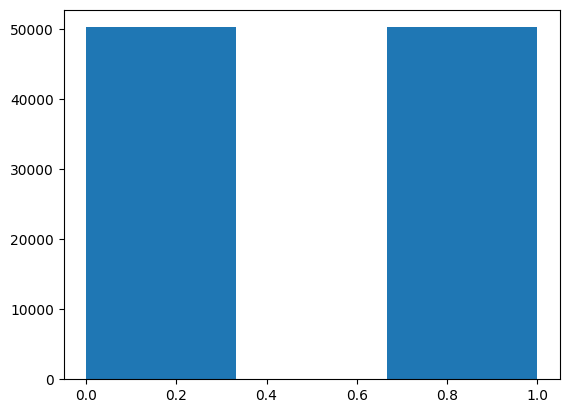

In [ ]:
plt.hist(yres, bins=3)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(Xres, yres, test_size=0.2, random_state=23)

###Define dataset

In [ ]:
#Define a dataset for easy batch training
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, x, y, batch_size=64):
    #data
    self.x=x
    self.y=y

    #aux var
    self.N=len(x) #num of samples in data
    self.batch_size=batch_size

  def __len__(self): #returns num of samples in dataset
    return self.N

  def __getitem__(self, index):
    x = self.x[index]
    y= self.y[index]

    return x, y

In [ ]:
batch_size=64 #minibatch
dataset = CustomDataset(torch.Tensor(X_train), torch.Tensor(y_train), batch_size)
dataloader = DataLoader(dataset, batch_size, shuffle=True)

###Model

Let $x \in \mathbb{R}^k$ and $L_i(x) = \sigma(W_ix+b_i)$ with $W_i \in \mathbb{R}^{k \times d}$, $b_i \in \mathbb{R}^d$, and nonlinearity $\sigma(\cdot)$, then define out fully connected neural network with $n$ layers as
$$N(x) = L_n(L_{n-1}(...(L_1(L_0(x)))...))$$

In [ ]:
class Dense(nn.Module):
  def __init__(self, num_neurons):
    #num_neurons has form [x0, x1, x2], where x0 input dimension to layer 0,
    #x1 output dimension layer 0/input dimension layer 1, etc. ,
    #until x2 output dimension of layer len(num_neurons-1)
    super(Dense, self).__init__()

    self.Layers = nn.ModuleList([nn.Linear(num_neurons[0], num_neurons[1])])
    for i in range(1, len(num_neurons)-1):
      self.Layers.append(nn.Linear(num_neurons[i], num_neurons[i+1]))

    #self.activation = nn.ReLU() #BAD
    self.activation =nn.Tanh()
    self.sigmoid =nn.Sigmoid()

  def forward(self, x):
    out = self.Layers[0](x)
    for i in range(1, len(self.Layers)):
      out = self.activation(out)
      out = self.Layers[i](out)

    return self.sigmoid(out)

###Training

####Training 1 (Smaller network, Sigmoid() activation)

In [ ]:
indim=len(X_train[0])
outdim=len(y_train[0])
num_neurons = [indim, 64, 64, 64, outdim]
modelNN = Dense(num_neurons)
optimizerNN = torch.optim.Adam(modelNN.parameters(), lr=0.001)
#BCELoss is Binary Cross Entropy and is "used as a proxy for ROC-AUC metric"
#https://github.com/iridiumblue/roc-star
loss_fn = nn.BCELoss()

In [ ]:
epochs = 300
loss_hist=[]
roc_auc_hist=[]

#Define the training loop
for i in tqdm.tqdm(range(epochs)):
  modelNN.train()

  for batch, (x, y) in enumerate(dataloader):
    optimizerNN.zero_grad()

    pred=modelNN(x)
    #print("pred", pred)
    #print("y", y)
    loss =loss_fn (pred, y)

    loss.backward()
    optimizerNN.step()

    loss_hist.append(loss.item())

  if i%10==0:
    print("\n Epoch: ", i, "  Loss: ", loss_hist[-1])
    modelNN.eval()
    print("Train ROC:", roc_auc_score(y_train, modelNN(torch.Tensor(X_train)).detach().numpy()))
    print("Test ROC:", roc_auc_score(y_val, modelNN(torch.Tensor(X_val)).detach().numpy()))
    roc_auc_hist.append(roc_auc_score(y_val, modelNN(torch.Tensor(X_val)).detach().numpy()))
    #Check validation set here

    #for name, parameter in modelNN.named_parameters():
      #print(name, parameter.grad.data)

  0%|          | 0/300 [00:00<?, ?it/s]


 Epoch:  0   Loss:  0.7032724022865295


  0%|          | 1/300 [00:02<11:21,  2.28s/it]

Train ROC: 0.26568460087638723
Test ROC: 0.2647778009541655


  3%|▎         | 10/300 [00:19<08:07,  1.68s/it]


 Epoch:  10   Loss:  0.6941470503807068
Train ROC: 0.8102251490639407


  4%|▎         | 11/300 [00:22<09:22,  1.95s/it]

Test ROC: 0.8079485818249779


  7%|▋         | 21/300 [00:38<08:44,  1.88s/it]


 Epoch:  20   Loss:  0.6913605332374573
Train ROC: 0.8617529546223655
Test ROC: 0.8589909732170402


 10%|█         | 31/300 [00:54<07:44,  1.73s/it]


 Epoch:  30   Loss:  0.6879164576530457
Train ROC: 0.8663532030650463
Test ROC: 0.8637008550011556


 13%|█▎        | 40/300 [01:10<08:38,  1.99s/it]


 Epoch:  40   Loss:  0.6805077791213989
Train ROC: 0.8693434893572295
Test ROC: 0.8666874216407073


 17%|█▋        | 51/300 [01:27<06:38,  1.60s/it]


 Epoch:  50   Loss:  0.6626425385475159
Train ROC: 0.8703358968369274
Test ROC: 0.8677281303973742


 20%|██        | 61/300 [01:44<06:31,  1.64s/it]


 Epoch:  60   Loss:  0.6238690614700317
Train ROC: 0.872331384876894
Test ROC: 0.8696858680320674


 24%|██▎       | 71/300 [01:59<05:42,  1.50s/it]


 Epoch:  70   Loss:  0.5580516457557678
Train ROC: 0.8765776516675385
Test ROC: 0.8737795049869508


 27%|██▋       | 81/300 [02:16<05:52,  1.61s/it]


 Epoch:  80   Loss:  0.48359307646751404
Train ROC: 0.8837589282119545
Test ROC: 0.8806860339236097


 30%|███       | 90/300 [02:30<05:07,  1.46s/it]


 Epoch:  90   Loss:  0.4318133294582367
Train ROC: 0.8910424684216969


 30%|███       | 91/300 [02:33<06:04,  1.74s/it]

Test ROC: 0.8876661194766011


 34%|███▎      | 101/300 [02:50<06:11,  1.87s/it]


 Epoch:  100   Loss:  0.4078485369682312
Train ROC: 0.8962772311645948
Test ROC: 0.8928368012177041


 37%|███▋      | 110/300 [03:06<06:08,  1.94s/it]


 Epoch:  110   Loss:  0.397475004196167
Train ROC: 0.900328854605069
Test ROC: 0.8970657309533705


 40%|████      | 121/300 [03:23<04:56,  1.66s/it]


 Epoch:  120   Loss:  0.39072445034980774
Train ROC: 0.9036236847338406
Test ROC: 0.9005420952136413


 44%|████▎     | 131/300 [03:40<04:48,  1.71s/it]


 Epoch:  130   Loss:  0.38550010323524475
Train ROC: 0.9061698383178083
Test ROC: 0.9031699862518063


 47%|████▋     | 141/300 [03:56<04:06,  1.55s/it]


 Epoch:  140   Loss:  0.38178884983062744
Train ROC: 0.9079782030851213
Test ROC: 0.9049907015245466


 50%|█████     | 151/300 [04:13<03:57,  1.59s/it]


 Epoch:  150   Loss:  0.3794424533843994
Train ROC: 0.9091009705171329
Test ROC: 0.9061126412962806


 53%|█████▎    | 160/300 [04:27<03:20,  1.44s/it]


 Epoch:  160   Loss:  0.3779091238975525
Train ROC: 0.9097622221844195


 54%|█████▎    | 161/300 [04:29<03:54,  1.68s/it]

Test ROC: 0.9067751697176231


 57%|█████▋    | 171/300 [04:46<04:03,  1.89s/it]


 Epoch:  170   Loss:  0.3768549859523773
Train ROC: 0.9101716057661147
Test ROC: 0.9071711894473014


 60%|██████    | 181/300 [05:02<03:20,  1.69s/it]


 Epoch:  180   Loss:  0.37607118487358093
Train ROC: 0.9104889484664088
Test ROC: 0.9074684303255274


 64%|██████▎   | 191/300 [05:18<02:57,  1.63s/it]


 Epoch:  190   Loss:  0.3754369616508484
Train ROC: 0.9107711782202594
Test ROC: 0.9077277587845058


 67%|██████▋   | 201/300 [05:35<02:46,  1.68s/it]


 Epoch:  200   Loss:  0.3748787045478821
Train ROC: 0.911026883710391
Test ROC: 0.9079587517622579


 70%|███████   | 210/300 [05:49<02:22,  1.58s/it]


 Epoch:  210   Loss:  0.3743540942668915
Train ROC: 0.9112608532764406
Test ROC: 0.9081793128947244


 74%|███████▎  | 221/300 [06:07<02:08,  1.62s/it]


 Epoch:  220   Loss:  0.37383344769477844
Train ROC: 0.9114899965148646
Test ROC: 0.9083945716254895


 77%|███████▋  | 230/300 [06:22<01:44,  1.49s/it]


 Epoch:  230   Loss:  0.37329617142677307
Train ROC: 0.9117263664276414
Test ROC: 0.9086219720160684


 80%|████████  | 240/300 [06:39<01:34,  1.57s/it]


 Epoch:  240   Loss:  0.37272709608078003
Train ROC: 0.9119777125644463


 80%|████████  | 241/300 [06:41<01:47,  1.83s/it]

Test ROC: 0.9088623492070833


 84%|████████▎ | 251/300 [06:58<01:31,  1.87s/it]


 Epoch:  250   Loss:  0.3721163272857666
Train ROC: 0.9122506500856694
Test ROC: 0.909124519120841


 87%|████████▋ | 261/300 [07:15<01:08,  1.75s/it]


 Epoch:  260   Loss:  0.37145528197288513
Train ROC: 0.9125442354685043
Test ROC: 0.9094107993961091


 90%|█████████ | 271/300 [07:31<00:51,  1.76s/it]


 Epoch:  270   Loss:  0.3707350492477417
Train ROC: 0.9128644618586326
Test ROC: 0.9097156949064278


 94%|█████████▎| 281/300 [07:47<00:29,  1.57s/it]


 Epoch:  280   Loss:  0.3699488341808319
Train ROC: 0.913213724043564
Test ROC: 0.9100512138867776


 97%|█████████▋| 290/300 [08:02<00:16,  1.64s/it]


 Epoch:  290   Loss:  0.36909133195877075
Train ROC: 0.9135928407725489


 97%|█████████▋| 291/300 [08:04<00:15,  1.73s/it]

Test ROC: 0.910416224696907


100%|██████████| 300/300 [08:20<00:00,  1.67s/it]


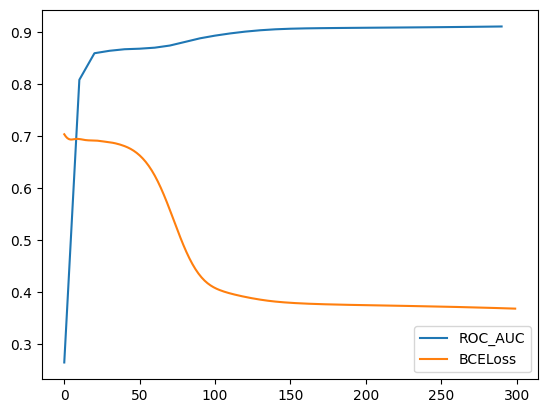

In [ ]:
plt.plot(np.arange(0, epochs, 10), roc_auc_hist)
plt.plot(np.arange(epochs), loss_hist)
plt.legend(['ROC_AUC', 'BCELoss'])

#### Training 2 (Larger Network, Tanh())

Here I add more neurons to the network, and change activation between layers to tanh(), which seemed to give better performance in previous tests than sigmoid.

In [ ]:
indim=len(X_train[0])
outdim=len(y_train[0])
num_neurons = [indim, 64, 128, 64, 32, outdim]
modelNN = Dense(num_neurons)
optimizerNN = torch.optim.Adam(modelNN.parameters(), lr=0.001)
#BCELoss is Binary Cross Entropy and is "used as a proxy for ROC-AUC metric"
#https://github.com/iridiumblue/roc-star
loss_fn = nn.BCELoss()

In [ ]:
epochs = 100
loss_hist=[]
roc_auc_hist=[]

#Define the training loop
for i in tqdm.tqdm(range(epochs)):
  modelNN.train()

  for batch, (x, y) in enumerate(dataloader):
    optimizerNN.zero_grad()

    pred=modelNN(x)
    loss =loss_fn (pred, y)

    loss.backward()
    optimizerNN.step()

  loss_hist.append(loss.item())

  if i%10==0:
    print("\n Epoch: ", i, "  Loss: ", loss_hist[-1])
    modelNN.eval()
    print("Train ROC:", roc_auc_score(y_train, modelNN(torch.Tensor(X_train)).detach().numpy()))
    print("Test ROC:", roc_auc_score(y_val, modelNN(torch.Tensor(X_val)).detach().numpy()))
    roc_auc_hist.append(roc_auc_score(y_val, modelNN(torch.Tensor(X_val)).detach().numpy()))

  0%|          | 0/100 [00:00<?, ?it/s]


 Epoch:  0   Loss:  0.1341310739517212


  1%|          | 1/100 [00:09<16:10,  9.80s/it]

Train ROC: 0.9326857814318887
Test ROC: 0.9288982869388009


 10%|█         | 10/100 [00:47<06:01,  4.02s/it]


 Epoch:  10   Loss:  0.14170287549495697


 11%|█         | 11/100 [00:52<06:40,  4.50s/it]

Train ROC: 0.9567970249512151
Test ROC: 0.9493288409686188


 20%|██        | 20/100 [01:28<05:15,  3.94s/it]


 Epoch:  20   Loss:  0.2871646285057068


 21%|██        | 21/100 [01:32<05:14,  3.98s/it]

Train ROC: 0.9776528257090452
Test ROC: 0.9648496675226118


 30%|███       | 30/100 [02:08<04:42,  4.03s/it]


 Epoch:  30   Loss:  0.21748997271060944


 31%|███       | 31/100 [02:12<04:35,  3.99s/it]

Train ROC: 0.9885465615193733
Test ROC: 0.9722077653944707


 40%|████      | 40/100 [02:49<04:17,  4.29s/it]


 Epoch:  40   Loss:  0.10904746502637863


 41%|████      | 41/100 [02:53<04:08,  4.21s/it]

Train ROC: 0.9923423429600332
Test ROC: 0.9739436027067054


 50%|█████     | 50/100 [03:30<03:24,  4.09s/it]


 Epoch:  50   Loss:  0.10872241854667664


 51%|█████     | 51/100 [03:35<03:38,  4.46s/it]

Train ROC: 0.9958049681963943
Test ROC: 0.9765139777584757


 60%|██████    | 60/100 [04:12<02:39,  3.99s/it]


 Epoch:  60   Loss:  0.18659354746341705


 61%|██████    | 61/100 [04:17<02:47,  4.31s/it]

Train ROC: 0.9972092843780705
Test ROC: 0.9769612770990159


 70%|███████   | 70/100 [04:53<02:01,  4.05s/it]


 Epoch:  70   Loss:  0.012422931380569935


 71%|███████   | 71/100 [04:57<01:57,  4.05s/it]

Train ROC: 0.9979312575288025
Test ROC: 0.9757587091947945


 80%|████████  | 80/100 [05:35<01:24,  4.22s/it]


 Epoch:  80   Loss:  0.0021599112078547478


 81%|████████  | 81/100 [05:39<01:18,  4.12s/it]

Train ROC: 0.9984320173565205
Test ROC: 0.9774282689565926


 90%|█████████ | 90/100 [06:16<00:41,  4.17s/it]


 Epoch:  90   Loss:  0.047149304300546646


 91%|█████████ | 91/100 [06:21<00:40,  4.52s/it]

Train ROC: 0.9989957489155294
Test ROC: 0.9770767389962687


100%|██████████| 100/100 [06:57<00:00,  4.17s/it]


Text(0.5, 1.0, 'Loan Approval Prediction w/ Dense NN')

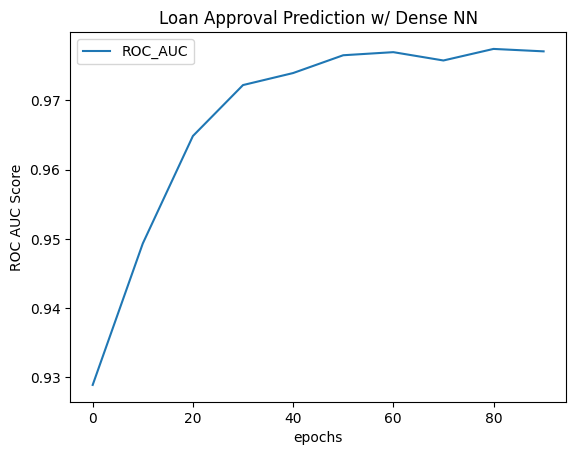

In [ ]:
plt.plot(np.arange(0, epochs, 10), roc_auc_hist)
plt.legend(['ROC_AUC'])
plt.xlabel('epochs')
plt.ylabel("ROC AUC Score")
plt.title('Loan Approval Prediction w/ Dense NN')

#### Training 3 (Remove SMOTE)

Remove the SMOTE in dataset to see how high we can get score

In [ ]:
indim=len(X_train[0])
outdim=len(y_train[0])
num_neurons = [indim, 64, 128, 64, 32, outdim]
modelNN = Dense(num_neurons)
optimizerNN = torch.optim.Adam(modelNN.parameters(), lr=0.001)
#BCELoss is Binary Cross Entropy and is "used as a proxy for ROC-AUC metric"
#https://github.com/iridiumblue/roc-star
loss_fn = nn.BCELoss()

In [ ]:
epochs = 100
loss_hist=[]
roc_auc_hist=[]

#Define the training loop
for i in tqdm.tqdm(range(epochs)):
  modelNN.train()

  for batch, (x, y) in enumerate(dataloader):
    optimizerNN.zero_grad()

    pred=modelNN(x)
    loss =loss_fn (pred, y)

    loss.backward()
    optimizerNN.step()

  loss_hist.append(loss.item())

  if i%10==0:
    print("\n Epoch: ", i, "  Loss: ", loss_hist[-1])
    modelNN.eval()
    print("Train ROC:", roc_auc_score(y_train, modelNN(torch.Tensor(X_train)).detach().numpy()))
    print("Test ROC:", roc_auc_score(y_val, modelNN(torch.Tensor(X_val)).detach().numpy()))
    roc_auc_hist.append(roc_auc_score(y_val, modelNN(torch.Tensor(X_val)).detach().numpy()))

  0%|          | 0/100 [00:00<?, ?it/s]


 Epoch:  0   Loss:  0.14521929621696472


  1%|          | 1/100 [00:07<12:22,  7.50s/it]

Train ROC: 0.9226619858363264
Test ROC: 0.9165906214436894


 11%|█         | 11/100 [00:41<03:48,  2.57s/it]


 Epoch:  10   Loss:  0.3550304174423218
Train ROC: 0.9363546204431408
Test ROC: 0.9255881244187298


 21%|██        | 21/100 [01:06<03:17,  2.50s/it]


 Epoch:  20   Loss:  0.649152934551239
Train ROC: 0.941584641520744
Test ROC: 0.9268613944342222


 30%|███       | 30/100 [01:28<02:46,  2.38s/it]


 Epoch:  30   Loss:  0.026871245354413986
Train ROC: 0.9482534026962803


 31%|███       | 31/100 [01:31<03:00,  2.62s/it]

Test ROC: 0.9231719307450776


 41%|████      | 41/100 [01:55<02:20,  2.37s/it]


 Epoch:  40   Loss:  0.011388474144041538
Train ROC: 0.9560623330163613
Test ROC: 0.9211519167295945


 51%|█████     | 51/100 [02:21<02:08,  2.63s/it]


 Epoch:  50   Loss:  0.05243045836687088
Train ROC: 0.9656811683728864
Test ROC: 0.9109521074630675


 60%|██████    | 60/100 [02:42<01:31,  2.29s/it]


 Epoch:  60   Loss:  0.021321730688214302
Train ROC: 0.9733224559773395


 61%|██████    | 61/100 [02:46<01:41,  2.61s/it]

Test ROC: 0.9028921705918292


 71%|███████   | 71/100 [03:10<01:09,  2.41s/it]


 Epoch:  70   Loss:  0.03083672560751438
Train ROC: 0.9811629194844362
Test ROC: 0.8981202589910033


 80%|████████  | 80/100 [03:34<00:54,  2.71s/it]


 Epoch:  80   Loss:  0.0476955771446228
Train ROC: 0.9872723714952737
Test ROC: 0.879803345989811


 90%|█████████ | 90/100 [03:58<00:23,  2.31s/it]


 Epoch:  90   Loss:  0.003609498031437397
Train ROC: 0.9908729679252191


 91%|█████████ | 91/100 [04:01<00:24,  2.70s/it]

Test ROC: 0.8851824376305087


100%|██████████| 100/100 [04:23<00:00,  2.63s/it]


####Training 4 (Larger Network)

In [ ]:
indim=len(X_train[0])
outdim=len(y_train[0])
num_neurons = [indim, 64, 128, 64, 32, outdim]
modelNN = Dense(num_neurons)
optimizerNN = torch.optim.Adam(modelNN.parameters(), lr=0.001)
#BCELoss is Binary Cross Entropy and is "used as a proxy for ROC-AUC metric"
#https://github.com/iridiumblue/roc-star
loss_fn = nn.BCELoss()

In [ ]:
epochs = 100
loss_hist=[]
roc_auc_hist=[]

#Define the training loop
for i in tqdm.tqdm(range(epochs)):
  modelNN.train()

  for batch, (x, y) in enumerate(dataloader):
    optimizerNN.zero_grad()

    pred=modelNN(x)
    loss =loss_fn (pred, y)

    loss.backward()
    optimizerNN.step()

  loss_hist.append(loss.item())

  if i%10==0:
    print("\n Epoch: ", i, "  Loss: ", loss_hist[-1])
    modelNN.eval()
    print("Train ROC:", roc_auc_score(y_train, modelNN(torch.Tensor(X_train)).detach().numpy()))
    print("Test ROC:", roc_auc_score(y_val, modelNN(torch.Tensor(X_val)).detach().numpy()))
    roc_auc_hist.append(roc_auc_score(y_val, modelNN(torch.Tensor(X_val)).detach().numpy()))

  0%|          | 0/100 [00:00<?, ?it/s]


 Epoch:  0   Loss:  0.20074541866779327
Train ROC: 0.9323513055310425
Test ROC: 0.9285546932852174


 10%|█         | 10/100 [01:01<06:52,  4.58s/it]


 Epoch:  10   Loss:  0.26870930194854736


 11%|█         | 11/100 [01:04<06:16,  4.23s/it]

Train ROC: 0.9552125789929338
Test ROC: 0.9479440789839433


 20%|██        | 20/100 [01:50<05:14,  3.93s/it]


 Epoch:  20   Loss:  0.19561262428760529


 21%|██        | 21/100 [01:56<06:02,  4.59s/it]

Train ROC: 0.9746408912048838
Test ROC: 0.9624625341833186


 30%|███       | 30/100 [03:04<08:21,  7.17s/it]


 Epoch:  30   Loss:  0.10710405558347702
Train ROC: 0.9861697361517381
Test ROC: 0.9689024221202954


 40%|████      | 40/100 [04:22<07:31,  7.52s/it]


 Epoch:  40   Loss:  0.03330446407198906


 41%|████      | 41/100 [04:32<08:00,  8.15s/it]

Train ROC: 0.9928563831414914
Test ROC: 0.9742121127708666


 50%|█████     | 50/100 [05:41<05:40,  6.81s/it]


 Epoch:  50   Loss:  0.026599258184432983


 51%|█████     | 51/100 [05:50<06:00,  7.36s/it]

Train ROC: 0.9951539272680612
Test ROC: 0.9740662151866815


 60%|██████    | 60/100 [07:06<05:48,  8.72s/it]


 Epoch:  60   Loss:  0.07564607262611389


 61%|██████    | 61/100 [07:17<06:01,  9.27s/it]

Train ROC: 0.9966363794919266
Test ROC: 0.9757185334950441


 70%|███████   | 70/100 [08:16<03:14,  6.47s/it]


 Epoch:  70   Loss:  0.0003152495191898197


 71%|███████   | 71/100 [08:24<03:22,  6.98s/it]

Train ROC: 0.9976078277938137
Test ROC: 0.9766266723258563


 80%|████████  | 80/100 [09:24<02:04,  6.24s/it]


 Epoch:  80   Loss:  0.06280922144651413
Train ROC: 0.9980677841979333


 81%|████████  | 81/100 [09:31<02:01,  6.41s/it]

Test ROC: 0.9763716529948218


 90%|█████████ | 90/100 [10:16<00:40,  4.08s/it]


 Epoch:  90   Loss:  0.42216405272483826


 91%|█████████ | 91/100 [10:21<00:37,  4.22s/it]

Train ROC: 0.9987856833685214
Test ROC: 0.9760208445169287


100%|██████████| 100/100 [10:59<00:00,  6.60s/it]


Text(0.5, 1.0, 'Loan Approval Prediction w/ Dense NN')

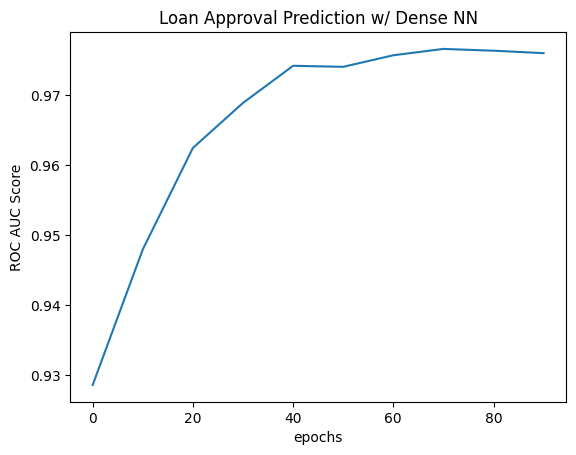

In [ ]:
plt.plot(np.arange(0, epochs, 10), roc_auc_hist)
#plt.plot(np.arange(epochs), loss_hist)
#plt.legend(['ROC_AUC', 'BCELoss'])
plt.xlabel('epochs')
plt.ylabel("ROC AUC Score")
plt.title('Loan Approval Prediction w/ Dense NN')

##### Training 4 Test

In [ ]:
X_test = test.drop('id', axis=1)

In [ ]:
X_test_dummy = pd.get_dummies(X_test, columns=['loan_intent','person_home_ownership', 'loan_grade', 'cb_person_default_on_file'], drop_first=True)
X_test_np=X_test_dummy.to_numpy(dtype='float')
X_test_scaled= StandardScaler().fit_transform(X_test_np)

In [ ]:
y_test = modelNN(torch.Tensor(X_test_scaled)).detach().numpy()

In [ ]:
y_test=np.reshape(y_test, len(y_test))

          id   loan_status
0      58645  1.000000e+00
1      58646  9.478860e-10
2      58647  9.999703e-01
3      58648  9.222338e-01
4      58649  7.858551e-01
...      ...           ...
39093  97738  2.003909e-06
39094  97739  6.041545e-06
39095  97740  6.355988e-07
39096  97741  4.942885e-02
39097  97742  9.977897e-01

[39098 rows x 2 columns]


(array([29089.,   865.,   458.,   332.,   257.,   207.,   168.,   163.,
          140.,   139.,   123.,   104.,   120.,    89.,   112.,    93.,
           90.,   120.,    85.,   106.,   113.,   108.,   118.,   121.,
          148.,   148.,   163.,   220.,   342.,  4757.]),
 array([1.92341950e-18, 3.33333351e-02, 6.66666701e-02, 1.00000001e-01,
        1.33333340e-01, 1.66666672e-01, 2.00000003e-01, 2.33333334e-01,
        2.66666681e-01, 3.00000012e-01, 3.33333343e-01, 3.66666675e-01,
        4.00000006e-01, 4.33333337e-01, 4.66666669e-01, 5.00000000e-01,
        5.33333361e-01, 5.66666663e-01, 6.00000024e-01, 6.33333325e-01,
        6.66666687e-01, 6.99999988e-01, 7.33333349e-01, 7.66666651e-01,
        8.00000012e-01, 8.33333313e-01, 8.66666675e-01, 8.99999976e-01,
        9.33333337e-01, 9.66666639e-01, 1.00000000e+00]),
 <BarContainer object of 30 artists>)

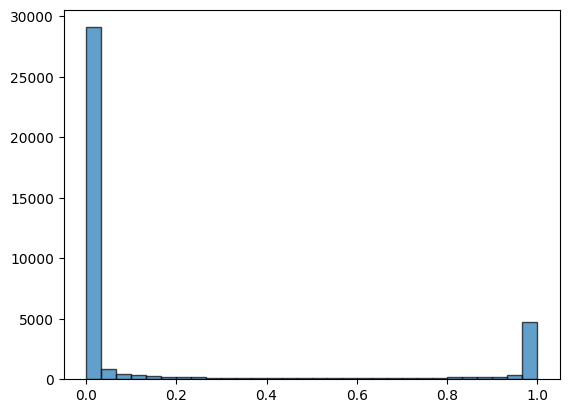

In [ ]:
submission = pd.DataFrame({
    'id': test['id'],
    'loan_status': y_test
})
print(submission)


plt.hist(submission["loan_status"], bins=30, edgecolor='k', alpha=0.7)

In [ ]:
submission.to_csv('./submission.csv', index=False)

### Training 5 (Tanh() Activation, smaller neurons)

In [ ]:
indim=len(X_train[0])
outdim=len(y_train[0])
num_neurons = [indim, 64, 64, 32, outdim]
modelNN = Dense(num_neurons)
optimizerNN = torch.optim.Adam(modelNN.parameters(), lr=0.001)
#BCELoss is Binary Cross Entropy and is "used as a proxy for ROC-AUC metric"
#https://github.com/iridiumblue/roc-star
loss_fn = nn.BCELoss()

In [ ]:
epochs = 100
loss_hist=[]
roc_auc_hist=[]

#Define the training loop
for i in tqdm.tqdm(range(epochs)):
  modelNN.train()

  for batch, (x, y) in enumerate(dataloader):
    optimizerNN.zero_grad()

    pred=modelNN(x)
    loss =loss_fn (pred, y)

    loss.backward()
    optimizerNN.step()

  loss_hist.append(loss.item())

  if i%10==0:
    print("\n Epoch: ", i, "  Loss: ", loss_hist[-1])
    modelNN.eval()
    print("Train ROC:", roc_auc_score(y_train, modelNN(torch.Tensor(X_train)).detach().numpy()))
    print("Test ROC:", roc_auc_score(y_val, modelNN(torch.Tensor(X_val)).detach().numpy()))
    roc_auc_hist.append(roc_auc_score(y_val, modelNN(torch.Tensor(X_val)).detach().numpy()))

  0%|          | 0/100 [00:00<?, ?it/s]


 Epoch:  0   Loss:  0.22973953187465668
Train ROC: 0.9317959038422832
Test ROC: 0.9285912170978686


 11%|█         | 11/100 [01:05<05:50,  3.93s/it]


 Epoch:  10   Loss:  0.36360883712768555
Train ROC: 0.9514061782108088
Test ROC: 0.9453943897229671


 20%|██        | 20/100 [01:36<04:41,  3.52s/it]


 Epoch:  20   Loss:  0.17071951925754547
Train ROC: 0.9633066599590379
Test ROC: 0.9541737388005295


 31%|███       | 31/100 [02:17<04:13,  3.68s/it]


 Epoch:  30   Loss:  0.42092642188072205
Train ROC: 0.9729050881284892
Test ROC: 0.9598514892657497


 41%|████      | 41/100 [02:50<03:20,  3.40s/it]


 Epoch:  40   Loss:  0.23090334236621857
Train ROC: 0.9787805473306928
Test ROC: 0.9641883201581252


 50%|█████     | 50/100 [03:33<03:50,  4.61s/it]


 Epoch:  50   Loss:  0.1356811374425888
Train ROC: 0.9831279168366707
Test ROC: 0.9671201183745121


 60%|██████    | 60/100 [04:09<02:28,  3.70s/it]


 Epoch:  60   Loss:  0.13593749701976776


 61%|██████    | 61/100 [04:13<02:31,  3.89s/it]

Train ROC: 0.9862071410401612
Test ROC: 0.9688098154027902


 71%|███████   | 71/100 [04:47<01:42,  3.54s/it]


 Epoch:  70   Loss:  0.17371313273906708
Train ROC: 0.9884051004267144
Test ROC: 0.9699835931930207


 80%|████████  | 80/100 [05:24<01:14,  3.73s/it]


 Epoch:  80   Loss:  0.1407189816236496


 81%|████████  | 81/100 [05:28<01:13,  3.85s/it]

Train ROC: 0.990855815520642
Test ROC: 0.9700798369726438


 90%|█████████ | 90/100 [05:59<00:36,  3.60s/it]


 Epoch:  90   Loss:  0.2503048777580261
Train ROC: 0.9920099492951153
Test ROC: 0.969883376318367


100%|██████████| 100/100 [06:33<00:00,  3.94s/it]


Text(0.5, 1.0, 'Loan Approval Prediction w/ Dense NN')

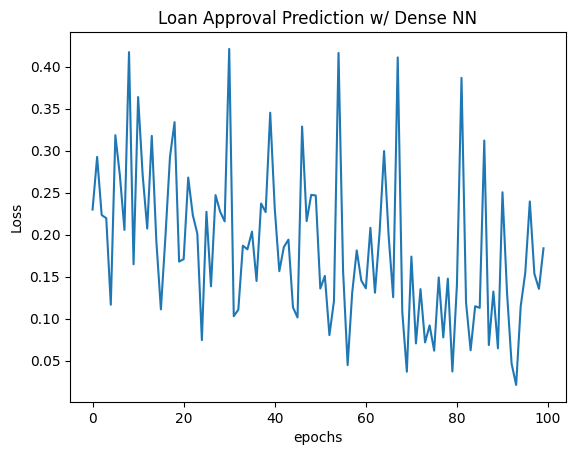

In [ ]:
#plt.plot(np.arange(0, epochs, 10), roc_auc_hist)
plt.plot(np.arange(epochs), loss_hist)
#plt.legend(['ROC_AUC', 'BCELoss'])
plt.xlabel('epochs')
plt.ylabel("Loss")
plt.title('Loan Approval Prediction w/ Dense NN')

Text(0.5, 1.0, 'Loan Approval Prediction w/ Dense NN')

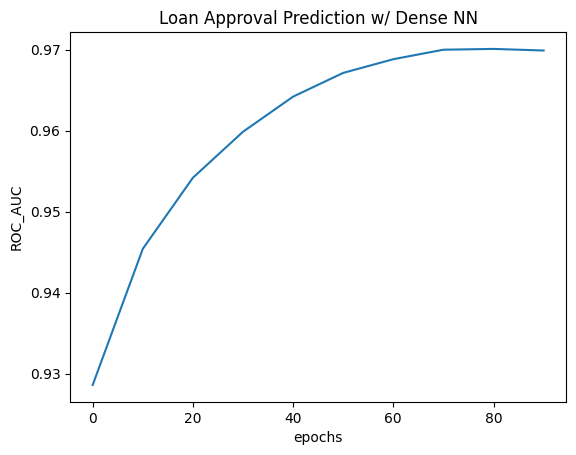

In [ ]:
plt.plot(np.arange(0, epochs, 10), roc_auc_hist)
#plt.plot(np.arange(epochs), loss_hist)
#plt.legend(['ROC_AUC', 'BCELoss'])
plt.xlabel('epochs')
plt.ylabel("ROC_AUC")
plt.title('Loan Approval Prediction w/ Dense NN')

          id  loan_status
0      58645     0.999964
1      58646     0.602937
2      58647     0.178548
3      58648     0.127761
4      58649     0.021513
...      ...          ...
39093  97738     0.000003
39094  97739     0.001566
39095  97740     0.033938
39096  97741     0.586595
39097  97742     0.512598

[39098 rows x 2 columns]


(array([24116.,  2311.,  1256.,   802.,   628.,   482.,   478.,   421.,
          345.,   268.,   275.,   248.,   216.,   239.,   217.,   213.,
          175.,   167.,   197.,   178.,   173.,   161.,   193.,   155.,
          190.,   204.,   196.,   246.,   350.,  3998.]),
 array([1.11159649e-14, 3.33333351e-02, 6.66666701e-02, 1.00000001e-01,
        1.33333340e-01, 1.66666672e-01, 2.00000003e-01, 2.33333334e-01,
        2.66666681e-01, 3.00000012e-01, 3.33333343e-01, 3.66666675e-01,
        4.00000006e-01, 4.33333337e-01, 4.66666669e-01, 5.00000000e-01,
        5.33333361e-01, 5.66666663e-01, 6.00000024e-01, 6.33333325e-01,
        6.66666687e-01, 6.99999988e-01, 7.33333349e-01, 7.66666651e-01,
        8.00000012e-01, 8.33333313e-01, 8.66666675e-01, 8.99999976e-01,
        9.33333337e-01, 9.66666639e-01, 1.00000000e+00]),
 <BarContainer object of 30 artists>)

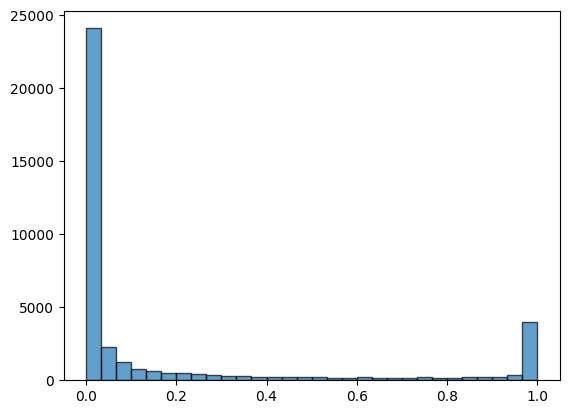

In [ ]:
submission = pd.DataFrame({
    'id': test['id'],
    'loan_status': y_test
})
print(submission)


plt.hist(submission["loan_status"], bins=30, edgecolor='k', alpha=0.7)

In [ ]:
submission.to_csv('./submission.csv', index=False)

## 2.2. CATBoost with Optuna

CATBoost
is suitable for categorical variables ("CAT"BOOST) and does not require one-hot encoding; this is the same for LightGBM as well. We expect that CATboost and LightGBM will show good performance over other methods.

In [ ]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

train.info(10)
test.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [ ]:
ID = test['id']
X_train = train.drop(['loan_status', 'id'], axis=1)
y_train = train['loan_status']
X_test = test.drop('id', axis=1)

X_train.info(10)
y_train.info(10)
X_test.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 4.9+ MB
<class 'pandas.core.series.Series'>
RangeIndex: 58645 entries, 0 to 58644
Series name: l

In [ ]:
train_categorical_var = train.select_dtypes(include = ['object']).columns
print(train_categorical_var)

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')


In [ ]:
test_categorical_var = test.select_dtypes(include = ['object']).columns
print(test_categorical_var)

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')


<font size = "5"> CATBoost model with Optuna </font>

| Parameter Category          | Parameter              | Value/Description                        |
|-----------------------------|------------------------|------------------------------------------|
| **Fixed Parameters**        | task_type              | 'cpu'                                    |
|                             | loss_function          | 'Logloss' (classification problem)       |
|                             | eval_metric            | 'AUC'                                    |
|                             | logging_level          | 'Silent'                                 |
|                             | random_state           | 23                                       |
|                             | use_best_model         | True                                     |
|                             | cat_features           | list(train_categorical_var)              |
| **Fine-Tuning Parameters**  | early_stopping_rounds  |                                          |
|                             | iterations             |                                          |
|                             | learning_rate          |                                          |
|                             | max_depth              |                                          |
| **Overfitting Related**     | min_data_in_leaf       |                                          |
|                             | bagging_temperature    |                                          |
|                             | leaf_reg               |                                          |
|                             | random_strength        |                                          |
|                             | colsample_bylevel      |                                          |

In [ ]:
# define tuning parameters

def objective(trial):
    params = {
        'task_type' : 'CPU',
        'loss_function' :'Logloss',
        'eval_metric' :'AUC',
        'random_state' : 23,
        'use_best_model' : True,
        'cat_features' : list(train_categorical_var),
        'logging_level' : 'Silent',
        'early_stopping_rounds' : 300,
        'iterations' : trial.suggest_int('iterations', 100, 2000),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth' : trial.suggest_int('max_depth', 4, 10),
        'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 20, 50),
        'bagging_temperature' : trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'l2_leaf_reg' : trial.suggest_float('l2_leaf_reg', 0.1, 1.0, log=True),
        'random_strength' : trial.suggest_float('random_strength', 0.0, 1.0),
        #'colsample_bylevel' : trial.suggest_float('colsample_bylevel', 0.1, 1.0) #not working under the GPU setting
        }

    # Fit the model
    model = CatBoostClassifier(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)

    # creating empty scores list to save AUC scores
    scores = []

    for train_idx, valid_idx in cv.split(X_train, y_train):
       X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
       y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

       model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold))
       y_pred_proba = model.predict_proba(X_val_fold)[:, 1]

       score = roc_auc_score(y_val_fold, y_pred_proba)
       scores.append(score)

       mean_score = np.mean(scores)
       print(f"Mean ROC-AUC Score = {mean_score: .5f}")
       return mean_score

run = 1

if run == 1:
    start_time = time.time()

    study = optuna.create_study(
        sampler=TPESampler(n_startup_trials=30, multivariate=True, seed=23),
        direction="maximize")

    study.optimize(objective, n_trials=100)

    end_time = time.time()
    time_elapsed = end_time - start_time
    print(f"Time elapsed: {time_elapsed} seconds")
    print('Best value:', study.best_value)
    print('Best trial:', study.best_trial.params)

In [ ]:
# record the best parameters
# From the 1st run, the 59th trial showed the highest ROC value, 0.9595
best_params = study.best_trial.params
print(best_params)


best_params = {
    #'task_type' : 'CPU',
    #'loss_function' :'Logloss',
    'cat_features' : list(train_categorical_var),
    'logging_level' : 'Silent',
    'iterations': 1658,
    'learning_rate': 0.08874528556894964,
    'max_depth': 4,
    'min_data_in_leaf': 24,
    'bagging_temperature': 0.0033640914818988538,
    'l2_leaf_reg': 0.2771228280982402,
    'random_strength': 0.1184011143992667
    }

In [ ]:
# fit the model with the best parameters
final_model = CatBoostClassifier(**best_params)

In [ ]:
# model evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)
cv_splits = tqdm(cv.split(X_train, y_train), total=cv.get_n_splits(), desc="CV Progress")

scores = []
for train_idx, valid_idx in cv_splits:
  X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
  y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

  final_model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold))

  y_pred_proba = final_model.predict_proba(X_val_fold)[:, 1]
  score = roc_auc_score(y_val_fold, y_pred_proba)
  scores.append(score)

  #print(f'score: {score:.5f}')

  print(f"Mean ROC-AUC Score = {np.mean(scores):.5f}")


CV Progress:  20%|██        | 1/5 [01:45<07:02, 105.61s/it]

Mean ROC-AUC Score = 0.95923


CV Progress:  40%|████      | 2/5 [03:13<04:44, 94.92s/it] 

Mean ROC-AUC Score = 0.95724


CV Progress:  60%|██████    | 3/5 [04:38<03:00, 90.39s/it]

Mean ROC-AUC Score = 0.95713


CV Progress:  80%|████████  | 4/5 [06:03<01:28, 88.58s/it]

Mean ROC-AUC Score = 0.95771


CV Progress: 100%|██████████| 5/5 [07:29<00:00, 89.90s/it]

Mean ROC-AUC Score = 0.95775


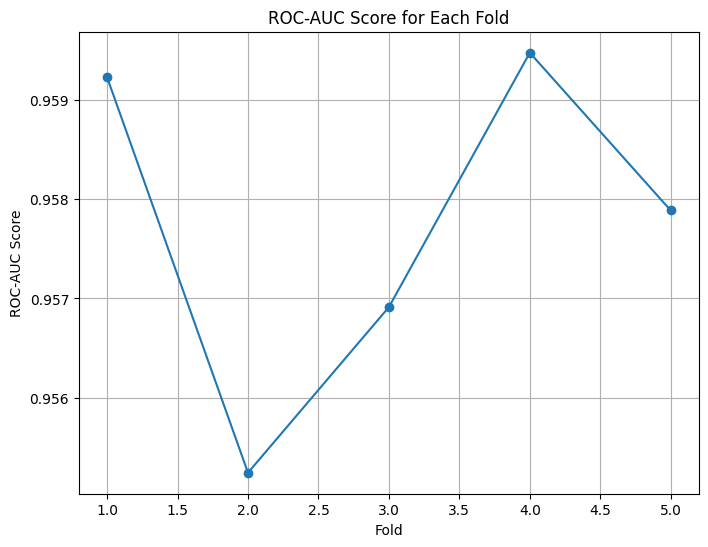

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(range(1, len(scores) + 1), scores, marker='o')
plt.xlabel('Fold')
plt.ylabel('ROC-AUC Score')
plt.title('ROC-AUC Score for Each Fold')
plt.grid(True)
plt.show()

In [ ]:
# plot the feature importance using the final model
feature_importance = final_model.get_feature_importance(prettified=True)
feature_importance

,Feature Id,Importances
0,person_income,23.457628
1,loan_percent_income,19.196657
2,loan_int_rate,17.714144
3,person_home_ownership,12.858895
4,loan_intent,7.426382
5,loan_grade,6.016726
6,person_emp_length,4.955083
7,loan_amnt,3.659063
8,person_age,2.967932
9,cb_person_cred_hist_length,1.437186


In [ ]:
# make predictions on the test data, using the final model
predictions = final_model.predict_proba(X_test)[:, 1]

In [ ]:
# put the predictions on the submission data file
submission = pd.DataFrame({"id": ID, "loan_status": predictions})
submission

,id,loan_status
0,58645,0.999563
1,58646,0.024848
2,58647,0.718238
3,58648,0.010939
4,58649,0.022928
...,...,...
39093,97738,0.036251
39094,97739,0.004696
39095,97740,0.004899
39096,97741,0.139200


(array([31169.,  2199.,   755.,   391.,   245.,   169.,   156.,   225.,
          528.,  3261.]),
 array([3.76473933e-05, 1.00033871e-01, 2.00030094e-01, 3.00026317e-01,
        4.00022540e-01, 5.00018764e-01, 6.00014987e-01, 7.00011210e-01,
        8.00007433e-01, 9.00003657e-01, 9.99999880e-01]),
 <BarContainer object of 10 artists>)

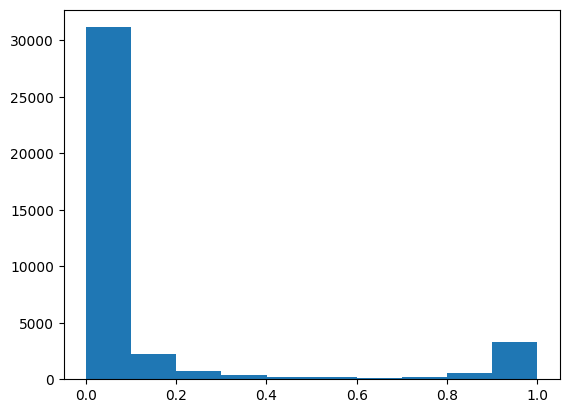

In [ ]:
# Check the distribution of loan_status probabilites
plt.hist(submission['loan_status'])

In [ ]:
submission.to_csv('./submission.csv', index=False)

## 2.3. LightGBM

In [ ]:
# Load data
train = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv")
print(train.shape)
print(test.shape)

X = train.drop(columns=['id', 'loan_status'])  # Drop the ID and target columns
y = train['loan_status']
print(y.value_counts())

# Checked: no missing values

# Handle categorical variables (one-hot encoding)
X = pd.get_dummies(X, drop_first=True)

In [ ]:
# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

In [ ]:
print(y_train.value_counts())
print(y_train.value_counts(1))
print(y_val.value_counts())
print(y_val.value_counts(1))

In [ ]:
# Updating LightGBM with optimized parameters
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    #num_leaves= 13,
    min_data_in_leaf = 90,
    max_depth = 20,
    learning_rate=0.1,
    n_estimators=100,
    #random_state=42,
)

# Fit the model on the training data
lgb_model.fit(X_train, y_train)

# Predict probabilities on the validation set
y_val_pred_proba = lgb_model.predict_proba(X_val)[:, 1]  # Probability of the positive class (loan approval)

# Evaluate the model using ROC AUC score
roc_auc = roc_auc_score(y_val, y_val_pred_proba)
print(f'Validation AUC: {roc_auc:.4f}')

In [ ]:
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log = True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log = True),
        'num_leaves': trial.suggest_int('num_leaves', 25, 100),
        'learning_rate':trial.suggest_float('learning_rate', 0.05, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.3, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.3, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_data_in_leaf':trial.suggest_int('min_data_in_leaf', 20, 100),
        'verbose': -1,
        #'device':gpu
    }

    dtrain = lgb.Dataset(X_train, label=y_train)
    dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)

    # Adding callbacks for early stopping and logging
    model = lgb.train(
        param,
        dtrain,
        valid_sets=[dval],
        callbacks=[early_stopping(100), log_evaluation(100)]
    )

    y_pred = model.predict(X_val)
    auc = roc_auc_score(y_val, y_pred)

    return auc




study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Adjust the number of trials as needed

print("Best parameters:", study.best_params)
print("Best AUC score:", study.best_value)


In [ ]:
best_params = study.best_params
best_params['objective'] = 'binary'
best_params['metric'] = 'auc'

# Initialize and train with LGBMClassifier
best_lgb_model = lgb.LGBMClassifier(**best_params)  # best_params from Optuna or manual tuning
best_lgb_model.fit(X, y)

In [ ]:

# Prepare test set
X_test = test.drop(columns=['id'])
X_test = pd.get_dummies(X_test, drop_first=True)

# Predict probabilities using LGBMClassifier
y_test_pred_lgb = best_lgb_model.predict_proba(X_test)[:, 1]

# Create a submission DataFrame
submission = pd.DataFrame({
    'id': test['id'],
    'loan_status': y_test_pred_lgb
})
print(submission)


plt.hist(submission["loan_status"], bins=30, edgecolor='k', alpha=0.7)

## 2.4. XGBoost

In [ ]:
# Define the classifier
xgb_mod = xgb.XGBClassifier(
    objective ='binary:logistic',
    eval_metric ='auc',
    random_state=42
)


# Fit the model on training data
xgb_mod.fit(X_train, y_train)

# Predict the probabilities of loan_status = 1 using the fitted model and the validation predictors
y_val_pred_prob = xgb_mod.predict_proba(X_val)[:, 1]

# Calculate the AUC scores using the validation loan_status and the predicted probabilities of loan_status
roc_auc = roc_auc_score(y_val, y_val_pred_prob)
print(f'Validation AUC: {roc_auc:.4f}')

In [ ]:
# Define objective function for Optuna
def objective(trial):
    # Suggest values for XGBoost hyperparameters
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'gamma': trial.suggest_int('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    # Train and evaluate XGBoost model with suggested parameters
    model = xgb.XGBClassifier(**param)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_val_pred_proba)

    return auc_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Adjust the number of trials as needed

print("Best parameters:", study.best_params)
print("Best AUC score:", study.best_value)


In [ ]:
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'auc'
best_params['use_label_encoder'] = False

best_xgb_model = xgb.XGBClassifier(**best_params)
best_xgb_model.fit(X, y)

In [ ]:
X_test = test.drop(columns=['id'])  # Drop the ID and target columns
X_test = pd.get_dummies(X_test, drop_first=True)

# Predict probabilities on the test set
y_test_pred_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

# Create a submission DataFrame
submission = pd.DataFrame({
    'id': test['id'],
    'loan_status': y_test_pred_xgb
})
print(submission)


plt.hist(submission["loan_status"], bins=30, edgecolor='k', alpha=0.7)

In [ ]:
submission.to_csv('submission.csv', index=False)

# Step 3. Weighting

We also decided to utilize ensemble learning to weight the outputs of our various approachs for a combined prediction, hopefully thereby lending the stengths of each to the final output.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
cat = pd.read_csv("./submission_CATboost_v1.csv")
lgb = pd.read_csv("./submission_lgb.csv")
xgb = pd.read_csv("./submission_xgb.csv")
NN = pd.read_csv("./submission (2).csv")

pred_cat = cat['loan_status']
pred_lgb = lgb['loan_status']
pred_xgb = xgb['loan_status']
pred_NN = NN['loan_status']

In [ ]:
pred_com = 0.7* pred_cat + 0.25*pred_lgb +0.05*pred_NN

submission = pd.DataFrame({
    'id': test['id'],
    'loan_status': pred_com
})
print(submission)

submission.to_csv('submission.csv', index=False)

          id  loan_status
0      58645     0.994885
1      58646     0.048715
2      58647     0.675521
3      58648     0.015771
4      58649     0.058966
...      ...          ...
39093  97738     0.031584
39094  97739     0.004935
39095  97740     0.006892
39096  97741     0.250544
39097  97742     0.929765

[39098 rows x 2 columns]
